# Побудуємо нашу модель

Берем готовий код з минулих заннять

Будуємо модель, графік лосу для кожної епохи

In [1]:
from pathlib import Path
import torch
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

Using device: cpu
# Params: 159010
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.321859
Train Epoch: 0 [10000/60000 (17%)]	Loss: 0.181064
Train Epoch: 0 [20000/60000 (33%)]	Loss: 0.212651
Train Epoch: 0 [30000/60000 (50%)]	Loss: 0.022429
Train Epoch: 0 [40000/60000 (67%)]	Loss: 0.043178
Train Epoch: 0 [50000/60000 (83%)]	Loss: 0.255571
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.033769
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.138570
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.105234
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.012995
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.030463
Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.130743
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.015251
Train Epoch: 2 [10000/60000 (17%)]	Loss: 0.133727
Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.111276
Train Epoch: 2 [30000/60000 (50%)]	Loss: 0.013575
Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.021744
Train Epoch: 2 [50000/60000 (83%)]	Loss: 0.077513

Test set: Average loss: 0.0149, Accuracy: 9557/10000 (96%)



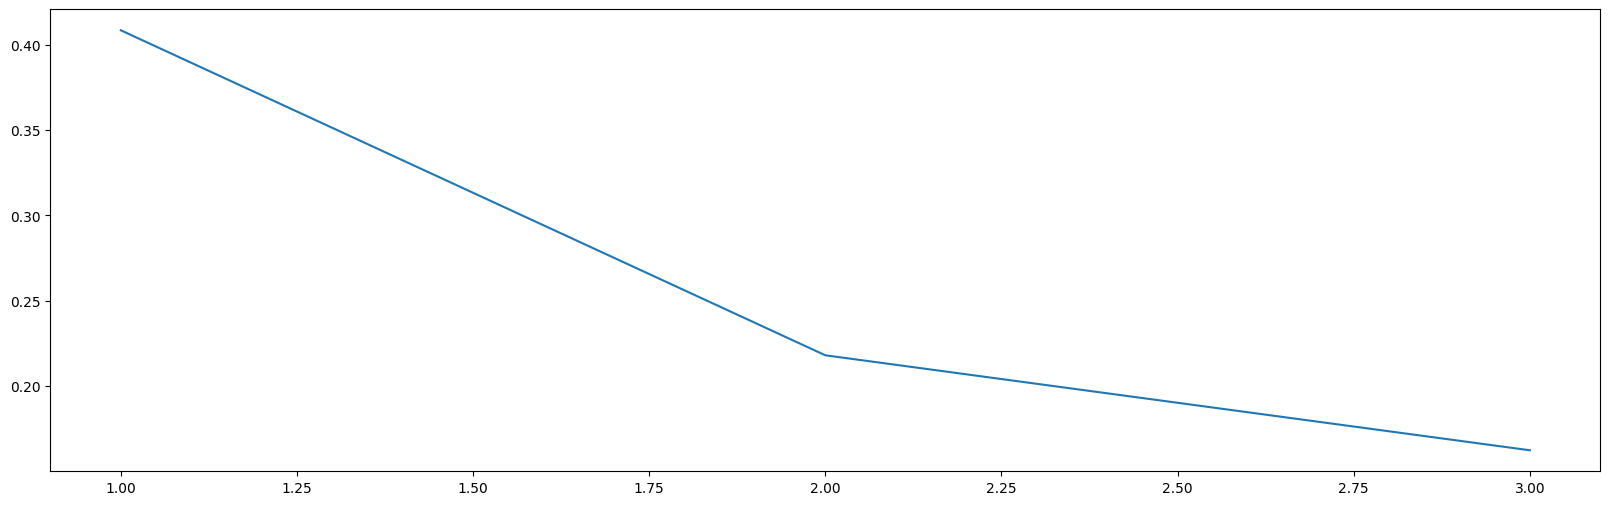

In [2]:
torch.manual_seed(1337)

class MnistMlp(torch.nn.Module):
    
    def __init__(self, inputnodes: int, hiddennodes: int, outputnodes: int) -> None:
        super().__init__()

        # number of nodes (neurons) in input, hidden, and output layer
        self.wih = torch.nn.Linear(in_features=inputnodes, out_features=hiddennodes)
        self.who = torch.nn.Linear(in_features=hiddennodes, out_features=outputnodes)
        self.activation = torch.nn.Sigmoid()

    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = self.wih(x)
        out = self.activation(out)
        out = self.who(out)
        return out


class MnistDataset(Dataset):
    
    def __init__(self, filepath: Path) -> None:
        super().__init__()

        self.data_list = None
        with open(filepath, "r") as f:
            self.data_list = f.readlines()

        # conver string data to torch Tensor data type
        self.features = []
        self.targets = []
        for record in self.data_list:
            all_values = record.split(",")
            features = np.asfarray(all_values[1:])
            target = int(all_values[0])
            self.features.append(features)
            self.targets.append(target)

        self.features = torch.tensor(np.array(self.features), dtype=torch.float) / 255.0
        self.targets = torch.tensor(np.array(self.targets), dtype=torch.long)
        # print(self.features.shape)
        # print(self.targets.shape)
        # print(self.features.max(), self.features.min())

    
    def __len__(self) -> int:
        return len(self.features)
    
    def __getitem__(self, index):
        return self.features[index], self.targets[index]


if __name__ == "__main__":

    total_losses = []
    
    # Device for training
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # NN architecture:
    # number of input, hidden and output nodes
    input_nodes = 784
    hidden_nodes = 200
    output_nodes = 10

    # learning rate is 0.1
    learning_rate = 0.1
    # batch size
    batch_size = 10
    # number of epochs
    epochs = 3

    # Load mnist training and testing data CSV file into a datasets
    train_dataset = MnistDataset(filepath="./mnist_train.csv")
    test_dataset = MnistDataset(filepath="./mnist_test.csv")

    # Make data loaders
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

    # Define NN
    model = MnistMlp(inputnodes=input_nodes, 
                     hiddennodes=hidden_nodes, 
                     outputnodes=output_nodes)
    # Number of parameters in the model
    print(f"# Params: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
    model = model.to(device=device)
    
    # Define Loss
    criterion = torch.nn.CrossEntropyLoss()

    # Define optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    ##### Training! #####
    model.train()
    for epoch in range(epochs):
        losses = []
        for batch_idx, (features, target) in enumerate(train_loader):
            features, target = features.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(features)
            loss = criterion(output, target)
            losses.append(loss.item())
            loss.backward()
            optimizer.step()
            if batch_idx % 1000 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(features), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()))
        total_losses.append(sum(losses)/len(losses))
    
    ##### Testing! #####
    model.eval()
    test_loss = 0
    correct = 0
    with torch.inference_mode():
        for features, target in test_loader:
            features, target = features.to(device), target.to(device)
            output = model(features)
            test_loss += criterion(output, target).item()  # sum up batch loss
            losses.append(criterion(output, target).item())
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


    ##### Save Model! #####
    # https://pytorch.org/tutorials/beginner/saving_loading_models.html
    # torch.save(model.state_dict(), "mnist_001.pth")
    plt.figure(figsize=(20,6))
    plt.plot(range(1, epochs+1), total_losses)
    plt.savefig("loss.png")

# Будуємо confusion matrix

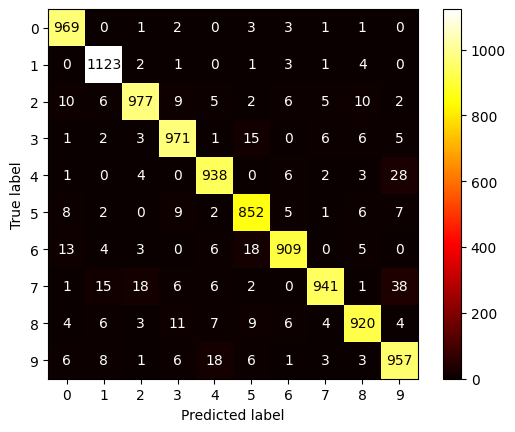

In [8]:
true_values = test_dataset.targets.to(device)
predicted_values = model(test_dataset.features.to(device)).argmax(axis=1)

matrix = confusion_matrix(true_values, predicted_values)
disp = ConfusionMatrixDisplay(confusion_matrix=matrix)

disp.plot(cmap=plt.colormaps["hot"])
plt.savefig("confusion_matrix.png")

# Будуємо графік для кожного класу

На графіку: precision, recall, f1 score

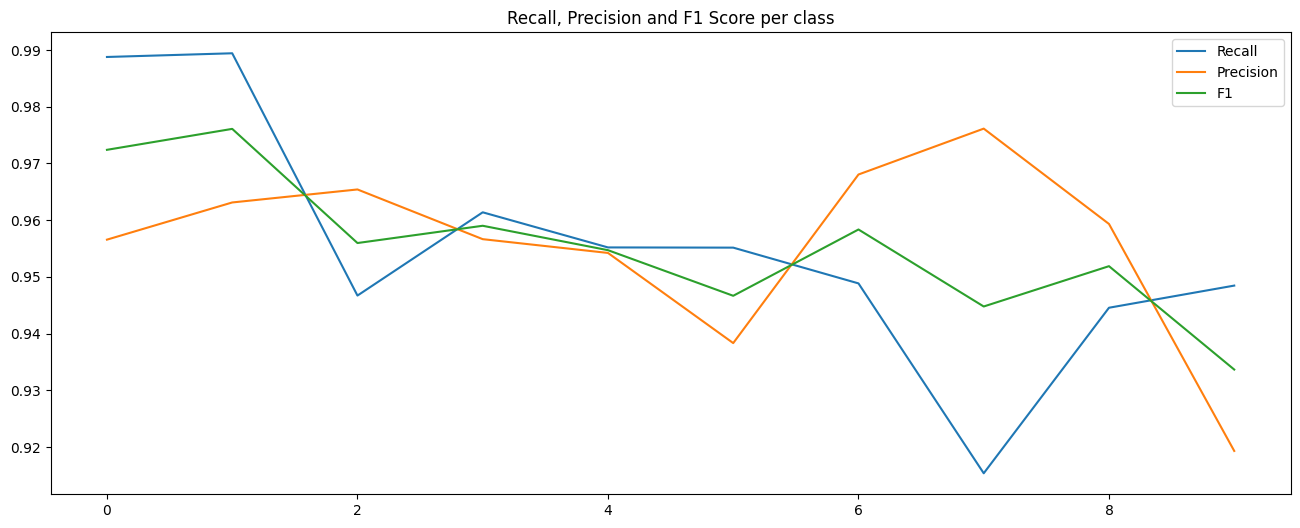

In [9]:
recall = matrix.diagonal() / matrix.sum(axis=1)
precision = matrix.diagonal() / matrix.sum(axis=0)
f1 = 2 * recall * precision / (recall + precision)

plt.figure(figsize=(16, 6))
plt.plot(recall, label="Recall")
plt.plot(precision, label="Precision")
plt.plot(f1, label="F1")
plt.legend()
plt.title("Recall, Precision and F1 Score per class")
plt.savefig("metrics_per_class.png")

# Будуємо графік для всього датасету

На графіку: precision, recall, f1 score

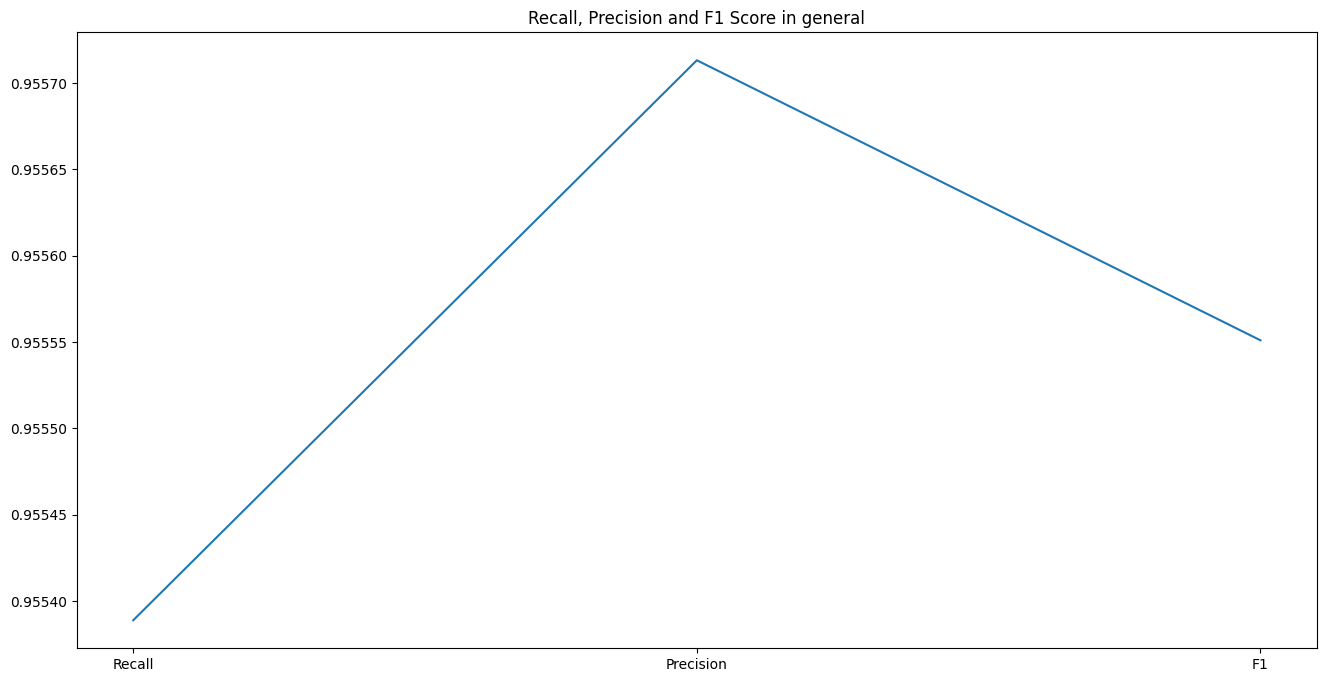

In [10]:
recall_general = np.mean(matrix.diagonal() / matrix.sum(axis=1))
precision_general = np.mean(matrix.diagonal() / matrix.sum(axis=0))
f1_general = 2 * recall_general * precision_general / (recall_general + precision_general)

plt.figure(figsize=(16, 8))
plt.plot(["Recall", 'Precision', 'F1'],[recall_general, precision_general, f1_general])
plt.title("Recall, Precision and F1 Score in general")
plt.savefig("metrics_in_general.png")

# Робимо classification report

In [53]:
report = classification_report(true_values, predicted_values, output_dict=True)
report

{'0': {'precision': 0.9565646594274433,
  'recall': 0.9887755102040816,
  'f1-score': 0.9724034119417964,
  'support': 980},
 '1': {'precision': 0.9631217838765008,
  'recall': 0.9894273127753304,
  'f1-score': 0.9760973489787048,
  'support': 1135},
 '2': {'precision': 0.9654150197628458,
  'recall': 0.9467054263565892,
  'f1-score': 0.9559686888454012,
  'support': 1032},
 '3': {'precision': 0.9566502463054187,
  'recall': 0.9613861386138614,
  'f1-score': 0.9590123456790123,
  'support': 1010},
 '4': {'precision': 0.9542217700915565,
  'recall': 0.955193482688391,
  'f1-score': 0.95470737913486,
  'support': 982},
 '5': {'precision': 0.9383259911894273,
  'recall': 0.9551569506726457,
  'f1-score': 0.9466666666666668,
  'support': 892},
 '6': {'precision': 0.9680511182108626,
  'recall': 0.9488517745302714,
  'f1-score': 0.9583552978386927,
  'support': 958},
 '7': {'precision': 0.9761410788381742,
  'recall': 0.9153696498054474,
  'f1-score': 0.9447791164658634,
  'support': 1028},

# Рахуємо точність для всієї моделі та для кожного класу окремо

In [54]:
accuracy = accuracy_score(true_values, predicted_values)
print("Overall Accuracy:", accuracy)

# Calculate accuracy per class
unique_classes = np.unique(true_values)
for class_label in unique_classes:
    class_indices = np.where(true_values == class_label)
    class_accuracy = accuracy_score(true_values[class_indices], predicted_values[class_indices])
    print(f"Accuracy for class {class_label}: {class_accuracy}")

Overall Accuracy: 0.9557
Accuracy for class 0: 0.9887755102040816
Accuracy for class 1: 0.9894273127753304
Accuracy for class 2: 0.9467054263565892
Accuracy for class 3: 0.9613861386138614
Accuracy for class 4: 0.955193482688391
Accuracy for class 5: 0.9551569506726457
Accuracy for class 6: 0.9488517745302714
Accuracy for class 7: 0.9153696498054474
Accuracy for class 8: 0.944558521560575
Accuracy for class 9: 0.9484638255698712
